In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
from PIL import Image
import time
import re


In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


# Entendimiento de dataset

## Lectura de Imagen

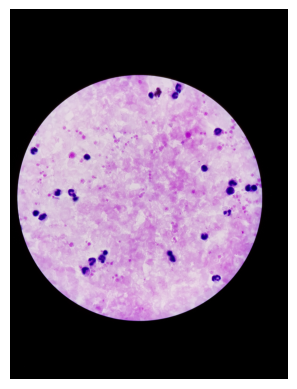

In [3]:
# Cargar la imagen desde el archivo
image = cv2.imread('/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Imagenes - Thick Smear/TF1N_1522/20171023_110309.jpg')

# Convertir la imagen de BGR a RGB (OpenCV carga imágenes en BGR por defecto)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Opcional: para no mostrar los ejes
plt.show()

## Lectura de Notas

In [4]:
# Lee el archivo txt, asumiendo que está delimitado por comas (CSV)
notas_110309 = pd.read_csv('/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Notas - Thick Smear/TF1N_1522/20171023_110309.txt',skiprows=1, header=None)

# Ver el contenido cargado
print(notas_110309.head())

      0         1           2       3  4        5       6        7       8
0   0-1  Parasite  No_Comment  Circle  2  2675.35  566.00  2678.00  579.25
1   0-2  Parasite  No_Comment  Circle  2  2271.25  544.95  2260.65  555.55
2   0-3  Parasite  No_Comment  Circle  2  2388.10  887.60  2383.75  902.75
3  0-31  Parasite  No_Comment  Circle  2  2427.40  489.30  2439.15  512.85
4   0-4  Parasite  No_Comment  Circle  2  1663.10  968.20  1660.90  983.70


## Unión notas e imagen

   ID_nota              Type     Comment   Shape  Label       X1       Y1  \
0      8-1          Parasite       troph  Circle      2  2556.00   593.55   
1     8-10          Parasite  No_Comment  Circle      2  1901.50  1863.25   
2     8-11          Parasite  No_Comment  Circle      2  1283.05  2010.60   
3     8-12          Parasite    schizont  Circle      2  2078.25  2836.30   
4     8-13          Parasite  No_Comment  Circle      2  1686.15   518.95   
5     8-14          Parasite  No_Comment  Circle      2  2216.40   577.85   
6      8-2          Parasite    schizont  Circle      2  1438.20   750.40   
7      8-3          Parasite  No_Comment  Circle      2  1779.35   935.20   
8      8-4          Parasite    schizont  Circle      2  2402.75  1095.85   
9      8-5          Parasite  No_Comment  Circle      2  2322.40  1192.30   
10     8-6          Parasite  No_Comment  Circle      2  1633.70  1163.45   
11     8-7          Parasite  No_Comment  Circle      2  1361.25  1192.05   

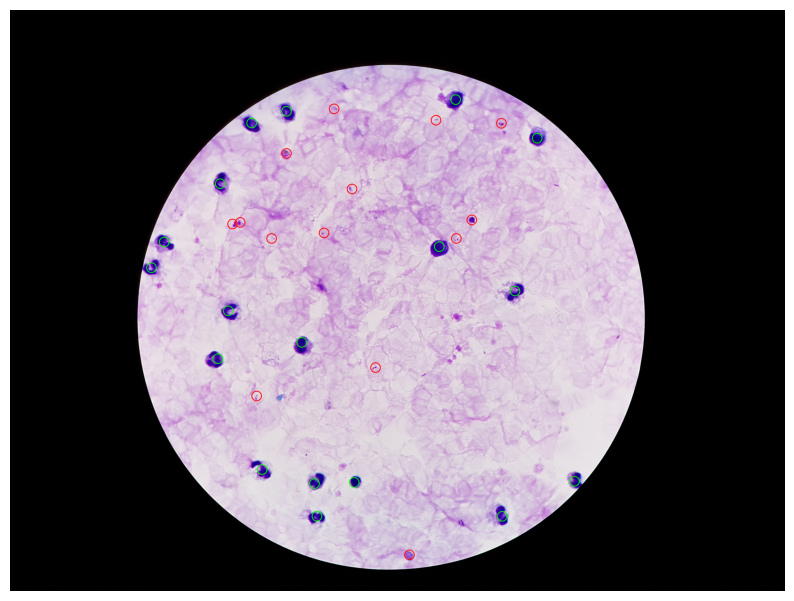

In [8]:
def procesar_imagen(carpeta, numero_foto):
    # Llamar a la función con las rutas
    #ruta_notas = '/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Notas - Thick Smear/TF1N_1522/20171023_110309.txt'

    ruta_notas = '/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Notas/' + carpeta + '/'+ numero_foto + '.txt'
    ruta_imagen = '/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/'  + carpeta + '/'+ numero_foto +'.jpg'
#/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/TF100_CS39/20170829_210416.jpg

    # Leer el archivo, saltando la primera línea
    notas = pd.read_csv(ruta_notas, skiprows=1, header=None)

    # Asignar los nombres de las columnas de acuerdo a la descripción
    notas.columns = [
        'ID_nota',             # Identificador de la anotación (ej. 0-1, 0-2, etc.)
        'Type',           # Tipo de célula (Parasite o White_Blood_Cell)
        'Comment',        # Comentario adicional (No_Comment)
        'Shape',          # Forma (Circle o Point)
        'Label',          # Etiqueta (número 1 o 2)
        'X1',             # Coordenada X del centro del círculo o punto
        'Y1',             # Coordenada Y del centro del círculo o punto
        'X2',             # Coordenada X en la circunferencia (solo si es Circle)
        'Y2'              # Coordenada Y en la circunferencia (solo si es Circle)
    ]

    # Ver el contenido cargado con las nuevas columnas
    print(notas)

    # Cargar la imagen
    image = cv2.imread(ruta_imagen)

    # Convertir la imagen de BGR a RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Redimensionar la imagen (ajustar según sea necesario)
    image_resized = cv2.resize(image_rgb, (image_rgb.shape[1] * 2, image_rgb.shape[0] * 2))  # Aumentar tamaño al doble

    # Cargar la imagen con PIL (Pillow) para obtener los metadatos EXIF
    image_pil = Image.open(ruta_imagen)

    # Obtener los metadatos EXIF
    try:
        exif = image_pil._getexif()
        print("EXIF metadata:", exif)  # Imprimir los metadatos para inspección
        if exif is not None:
            for tag, value in exif.items():
                if tag == 274:  # 274 es el tag para orientación
                    orientation = value
                    print("Orientation found:", orientation)
                    break
        else:
            orientation = None
            print("No EXIF data found.")
    except (AttributeError, KeyError, IndexError) as e:
        orientation = None
        print("Error accessing EXIF data:", e)

    print('Orientación: ', orientation)
    # Aplicar la rotación de acuerdo a la orientación EXIF (rotaciones de OpenCV)
    if orientation == 3:
        rotated_image2 = cv2.rotate(image_resized, cv2.ROTATE_180)  # Rota 180 grados
    elif orientation == 6:
        rotated_image2 = cv2.rotate(image_resized, cv2.ROTATE_90_COUNTERCLOCKWISE)  # Rota 270 grados en sentido antihorario
    elif orientation == 8:
        rotated_image2 = cv2.rotate(image_resized, cv2.ROTATE_90_CLOCKWISE)  # Rota 90 grados en sentido antihorario
    else:
        rotated_image2 = image_resized  # Si no hay rotación, mantener la imagen original

    # Iterar sobre las filas del DataFrame para obtener las coordenadas
    for index, row in notas.iterrows():
        x = row['X1']  # Coordenada X
        y = row['Y1']  # Coordenada Y

        # Dibujar un círculo o punto según la forma especificada
        if row['Shape'] == 'Circle':
            cv2.circle(rotated_image2, (int(x * 2), int(y * 2)), radius=50, color=(255, 0, 0), thickness=8)  # Rojo
        elif row['Shape'] == 'Point':
            cv2.circle(rotated_image2, (int(x * 2), int(y * 2)), radius=50, color=(0, 255, 0), thickness=8)  # Verde'''

    # Mostrar la imagen rotada con las coordenadas usando Matplotlib
    plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura de Matplotlib
    plt.imshow(rotated_image2)
    plt.axis('off')  # Opcional para no mostrar los ejes
    plt.show()

procesar_imagen('TF100_CS39','20170829_210416')


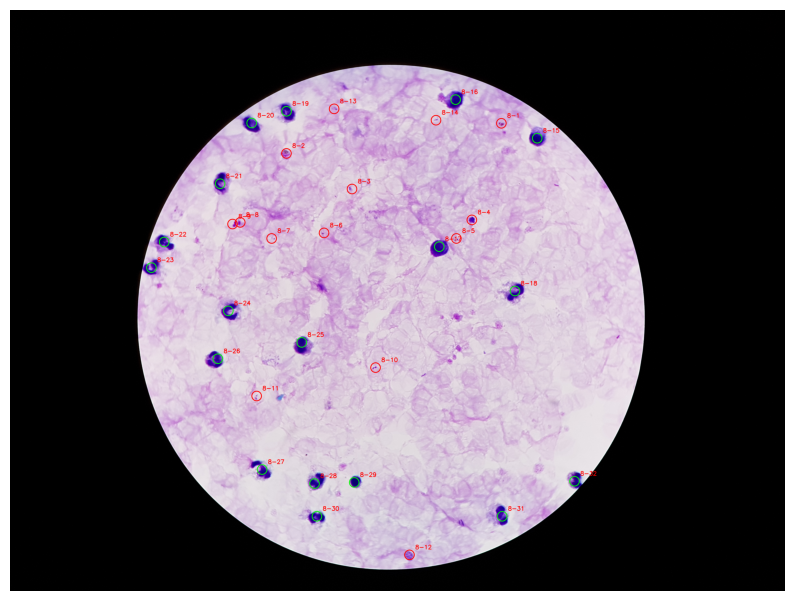

In [10]:
def procesar_imagen(carpeta, numero_foto):
    ruta_notas = '/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Notas/' + carpeta + '/'+ numero_foto + '.txt'
    ruta_imagen = '/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Imagenes/'  + carpeta + '/'+ numero_foto +'.jpg'

    # Leer el archivo, saltando la primera línea
    notas = pd.read_csv(ruta_notas, skiprows=1, header=None)

    # Asignar los nombres de las columnas de acuerdo a la descripción
    notas.columns = [
        'ID_nota', 'Type', 'Comment', 'Shape', 'Label', 'X1', 'Y1', 'X2', 'Y2'
    ]

    # Cargar la imagen
    image = cv2.imread(ruta_imagen)

    # Convertir la imagen de BGR a RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Redimensionar la imagen (ajustar según sea necesario)
    image_resized = cv2.resize(image_rgb, (image_rgb.shape[1] * 2, image_rgb.shape[0] * 2))

    # Cargar la imagen con PIL (Pillow) para obtener los metadatos EXIF
    image_pil = Image.open(ruta_imagen)

    # Obtener los metadatos EXIF
    try:
        exif = image_pil._getexif()
        orientation = None
        if exif is not None:
            for tag, value in exif.items():
                if tag == 274:  # 274 es el tag para orientación
                    orientation = value
                    break
    except (AttributeError, KeyError, IndexError) as e:
        orientation = None

    # Aplicar la rotación de acuerdo a la orientación EXIF
    if orientation == 3:
        rotated_image2 = cv2.rotate(image_resized, cv2.ROTATE_180)
    elif orientation == 6:
        rotated_image2 = cv2.rotate(image_resized, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif orientation == 8:
        rotated_image2 = cv2.rotate(image_resized, cv2.ROTATE_90_CLOCKWISE)
    else:
        rotated_image2 = image_resized

    # Iterar sobre las filas del DataFrame para obtener las coordenadas
    for index, row in notas.iterrows():
        x = int(row['X1'] * 2)  # Coordenada X
        y = int(row['Y1'] * 2)  # Coordenada Y
        id_nota = row['ID_nota']  # ID de la nota

        # Dibujar un círculo o punto según la forma especificada
        if row['Shape'] == 'Circle':
            cv2.circle(rotated_image2, (x, y), radius=50, color=(255, 0, 0), thickness=8)  # Rojo
        elif row['Shape'] == 'Point':
            cv2.circle(rotated_image2, (x, y), radius=50, color=(0, 255, 0), thickness=8)  # Verde

        # Agregar el ID de la nota cerca del círculo
        cv2.putText(rotated_image2, str(id_nota), (x + 60, y - 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 6)

    # Mostrar la imagen rotada con las coordenadas usando Matplotlib
    plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura de Matplotlib
    plt.imshow(rotated_image2)
    plt.axis('off')  # Opcional: para no mostrar los ejes
    plt.show()

procesar_imagen('TF100_CS39', '20170829_210416')


In [6]:
#procesar_imagen('TF1N_1522','111022')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Base de datos/Falciparum/Notas/TF1N_1522/111022.txt'

#Aplicación Método IGMS


El método Intensity-based Iterative Global Minimum Screening (IGMS) es una técnica utilizada para la detección rápida y automática de regiones de interés en imágenes, como posibles parásitos en muestras de sangre. IGMS se basa en el análisis iterativo de intensidades de píxeles para identificar mínimos globales, lo que permite localizar áreas que podrían contener características importantes, como parásitos o células, eliminando zonas irrelevantes o de fondo. Este enfoque es particularmente útil en aplicaciones de diagnóstico, ya que optimiza el preprocesamiento de imágenes, reduce el ruido y acelera la selección de candidatos para análisis posteriores, asegurando un procesamiento más eficiente y preciso.

## Procesamiento de Imagen

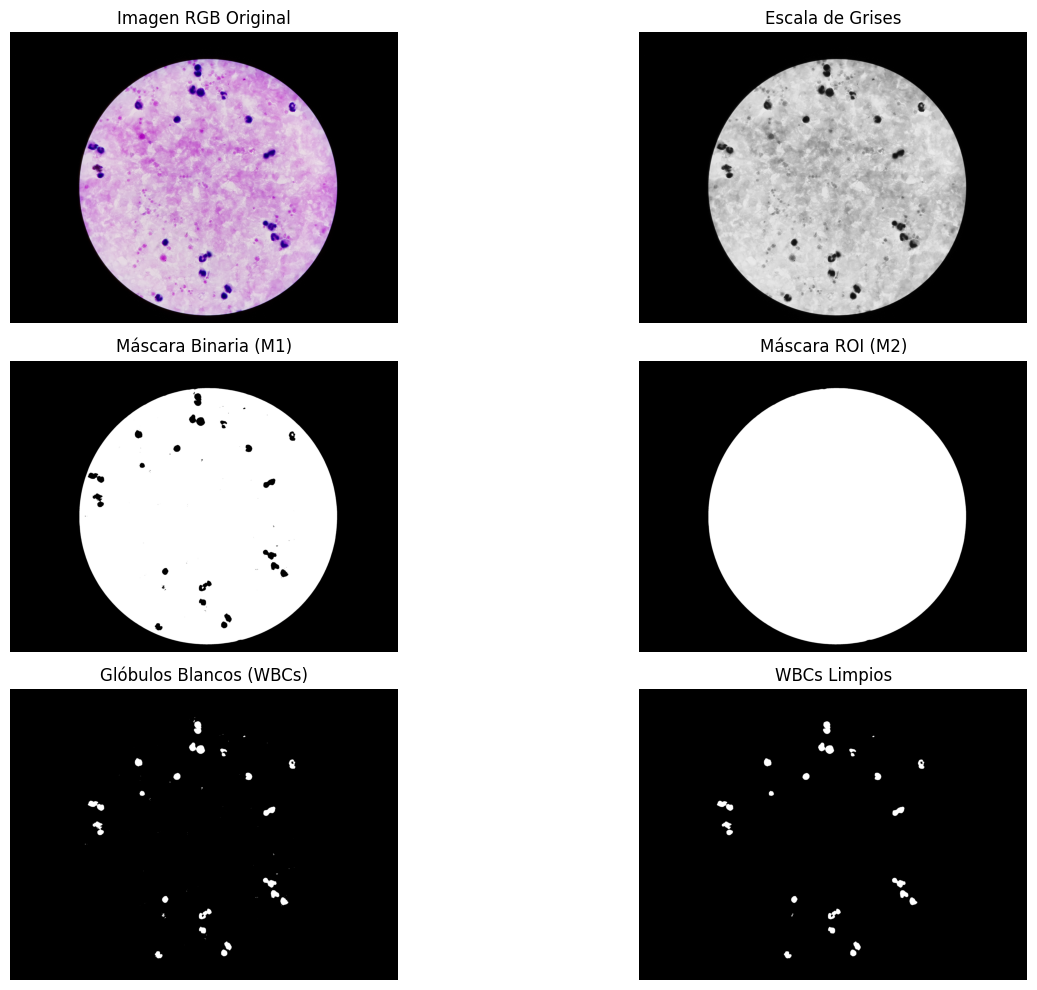

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Cargar la imagen RGB
ruta_imagen = "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Imagenes - Thick Smear/TF1N_1522/20171023_110309.jpg"  # Reemplaza con la ruta a tu imagen
image_rgb = cv2.imread(ruta_imagen)
image_rgb = cv2.rotate(image_rgb, cv2.ROTATE_90_COUNTERCLOCKWISE)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB para Matplotlib

# Paso 2: Convertir a escala de grises
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Paso 3: Generar la máscara binaria M1 usando el método de Otsu
_, mask_m1 = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
'''# Establecer un umbral manual (por ejemplo, 150)
threshold_value = 100

# Paso 3: Generar la máscara binaria M1 usando el umbral manual
_, mask_m1 = cv2.threshold(image_gray, threshold_value, 255, cv2.THRESH_BINARY)'''

# Paso 4: Rellenar los agujeros en M1 para obtener M2
contours, _ = cv2.findContours(mask_m1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una máscara llena (M2) con los agujeros rellenados
mask_m2 = np.zeros_like(mask_m1)
cv2.drawContours(mask_m2, contours, -1, (255), thickness=cv2.FILLED)

# Paso 5: Separar los glóbulos blancos (WBCs) restando M1 de M2
mask_wbcs = cv2.subtract(mask_m2, mask_m1)

# Paso 6: Filtrar el ruido para obtener glóbulos blancos limpios
# Aplicar operaciones morfológicas (apertura) para eliminar pequeñas áreas ruidosas
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
mask_clean_wbcs = cv2.morphologyEx(mask_wbcs, cv2.MORPH_OPEN, kernel)

# Restar mask_clean_wbcs de mask_wbcs para obtener los parásitos
mask_parasites_ = cv2.add(image_gray, mask_clean_wbcs)
mask_parasites = cv2.add(mask_parasites_,cv2.bitwise_not(mask_m2))

# Paso 7: Preparar las visualizaciones en Matplotlib
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.ravel()

titles = [
    "Imagen RGB Original", "Escala de Grises", "Máscara Binaria (M1)",
    "Máscara ROI (M2)", "Glóbulos Blancos (WBCs)", "WBCs Limpios"
]
images = [image_rgb, image_gray, mask_m1, mask_m2, mask_wbcs, mask_clean_wbcs]

for ax, title, img in zip(axes, titles, images):
    if len(img.shape) == 2:  # Escala de grises o máscaras binarias
        ax.imshow(img, cmap="gray")
    else:  # Imagen RGB
        ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


## Verificación con anotaciones

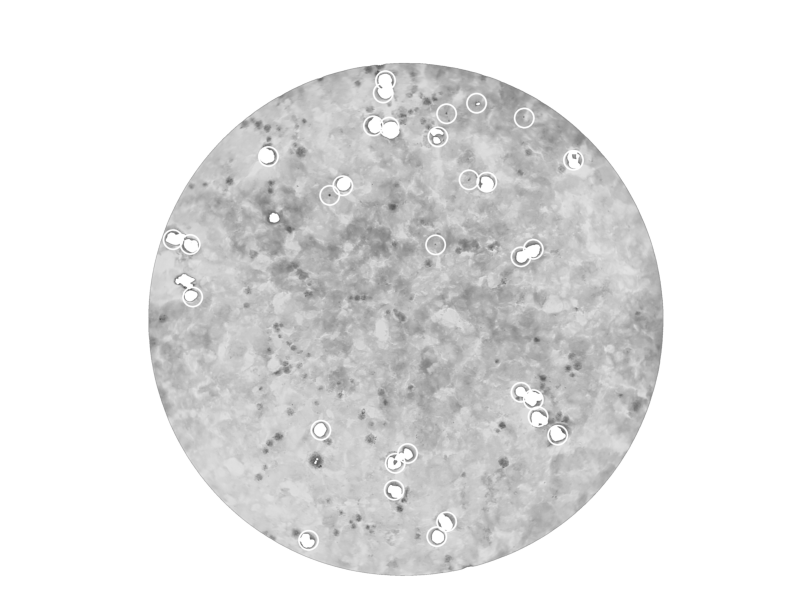

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Rotar la imagen 270 grados (90 en sentido antihorario)
rotated_image = mask_parasites.copy()

# Leer el archivo de notas, saltando la primera línea
ruta_notas = '/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Notas - Thick Smear/TF1N_1522/20171023_110309.txt'
notas = pd.read_csv(ruta_notas, skiprows=1, header=None)

# Asignar los nombres de las columnas de acuerdo a la descripción
notas.columns = [
    'ID_nota', 'Type', 'Comment', 'Shape', 'Label', 'X1', 'Y1', 'X2', 'Y2'
]

# Iterar sobre las filas del DataFrame para obtener las coordenadas
for index, row in notas.iterrows():
    x = row['X1']  # Coordenada X
    y = row['Y1']  # Coordenada Y

    # Dibujar un círculo o punto según la forma especificada
    if row['Shape'] == 'Circle':
        cv2.circle(rotated_image, (int(x), int(y)), radius=50, color=(255, 150, 0), thickness=8)  # Rojo
    elif row['Shape'] == 'Point':
        cv2.circle(rotated_image, (int(x), int(y)), radius=50, color=(255, 150, 0), thickness=8)  # Verde

# Convertir la imagen a RGB para mostrarla con Matplotlib
rotated_image_rgb = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)

# Mostrar la imagen rotada con los círculos en color usando Matplotlib
plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura
plt.imshow(rotated_image_rgb)  # Mostrar en formato RGB
plt.axis('off')  # Opcional para no mostrar los ejes
plt.show()

## Corte de Candidatos

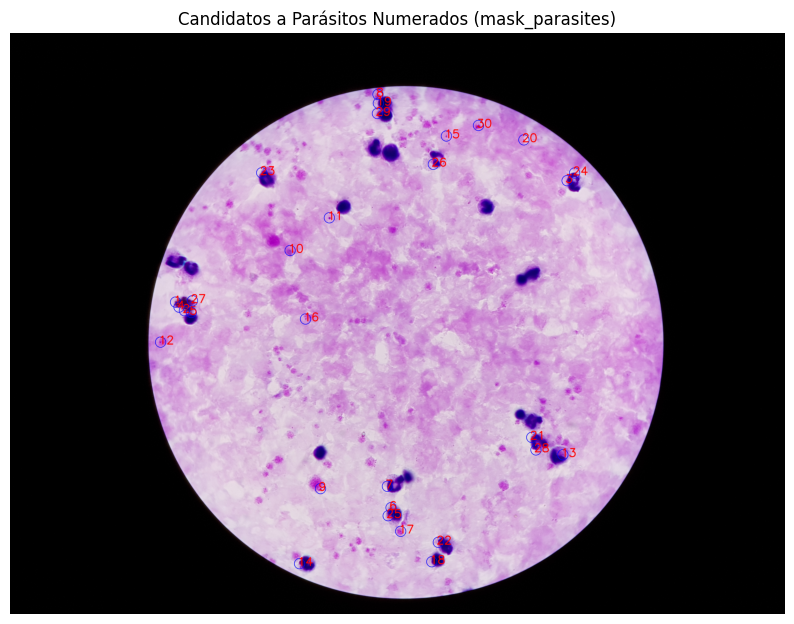

In [9]:
# Crear una copia de la máscara para modificarla durante el proceso
mask_to_process = mask_parasites.copy()
image_rgb2 = image_rgb.copy()
# Parámetros
radio_parasito = 27  # Radio de la ROI en píxeles
num_candidatos = 30  # Número máximo de candidatos a seleccionar

# Lista para almacenar las posiciones de los candidatos
parasite_candidates = []

# Parámetros de tiempo
tiempo_limite = 10  # Tiempo máximo en segundos

# Registrar el tiempo inicial
inicio = time.time()

# Proceso iterativo
while len(parasite_candidates) < num_candidatos:
    # Encuentra el píxel con intensidad mínima en la máscara
    min_val, _, min_loc, _ = cv2.minMaxLoc(mask_to_process)

    # Verificar si el tiempo límite ha sido alcanzado
    if time.time() - inicio > tiempo_limite:
        print(f"Se alcanzó el tiempo límite de {tiempo_limite} segundos.")
        break

    # Si ya no quedan píxeles negros válidos, romper el bucle
    if min_val == 255:  # No quedan píxeles negros en la máscara
        break

    # Validar que el píxel esté a suficiente distancia de los candidatos previos
    if all(
        np.sqrt((min_loc[0] - x) ** 2 + (min_loc[1] - y) ** 2) > radio_parasito
        for y, x in parasite_candidates
    ):
        parasite_candidates.append(min_loc)  # Agregar el candidato

        # Marcar la región como procesada (poner en blanco para ignorarla)
        cv2.circle(mask_to_process, min_loc, radio_parasito, (255), -1)

# Visualizar los resultados en `mask_parasites`
mask_with_circles = cv2.cvtColor(mask_parasites, cv2.COLOR_GRAY2BGR)  # Convertir a RGB para dibujar en color
for i, candidate in enumerate(parasite_candidates, start=1):
    # Dibujar círculos en rojo
    cv2.circle(image_rgb2, candidate, radio_parasito, (0, 0, 255), 2)
    # Agregar el número del candidato en azul
    cv2.putText(
        image_rgb2,
        str(i),
        (candidate[0] - 10, candidate[1] + 10),  # Ajustar la posición del texto
        cv2.FONT_HERSHEY_SIMPLEX,
        2,  # Tamaño de la fuente
        (255, 0, 0),  # Color del texto (azul)
        3,  # Grosor del texto
        cv2.LINE_AA,
    )

# Mostrar la máscara con los círculos y números
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb2)
plt.title("Candidatos a Parásitos Numerados (mask_parasites)")
plt.axis("off")
plt.show()


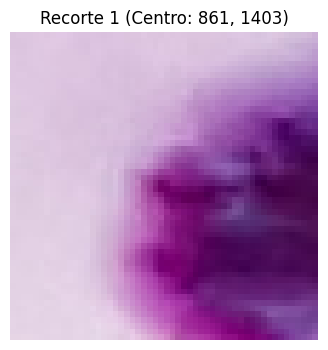

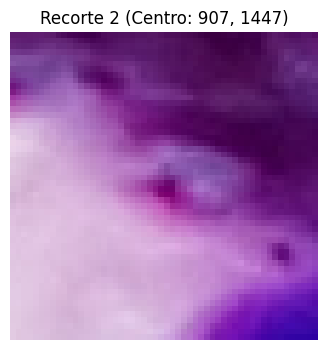

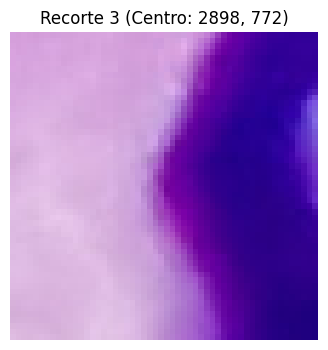

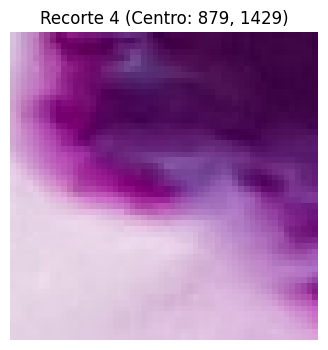

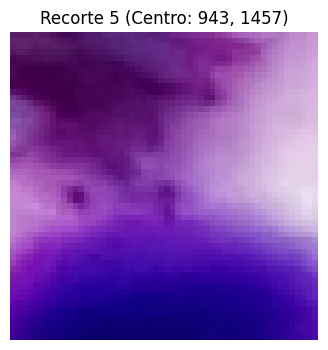

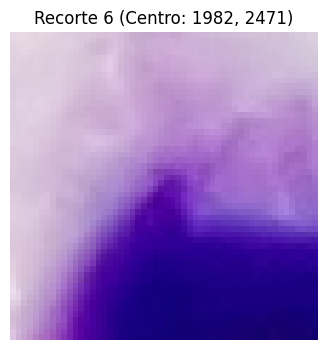

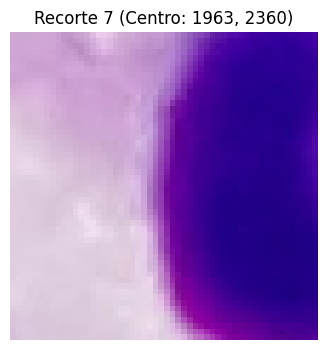

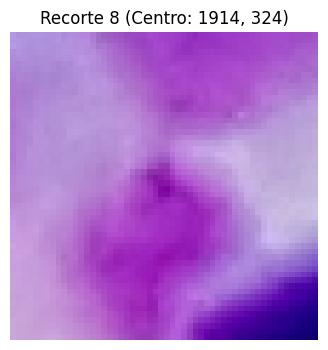

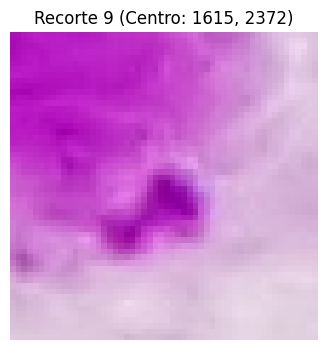

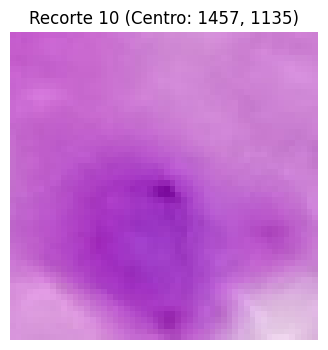

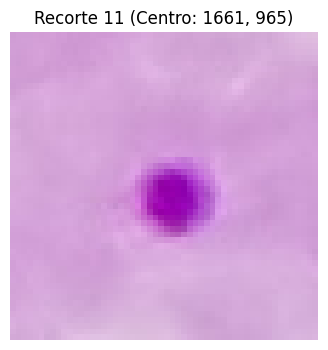

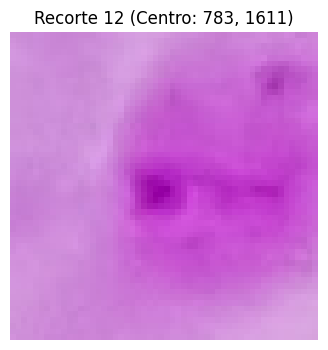

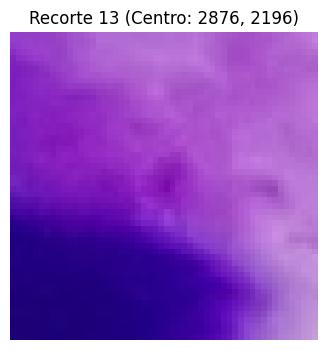

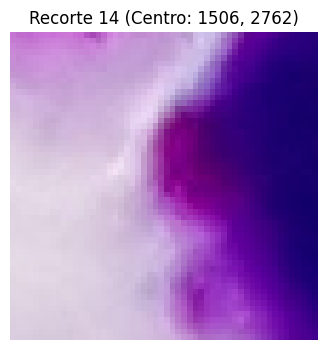

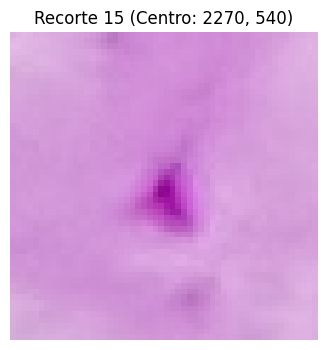

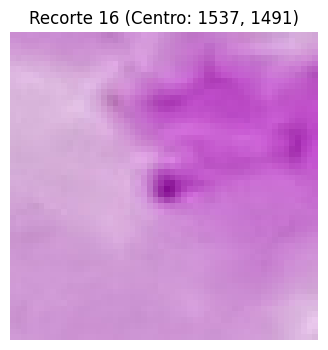

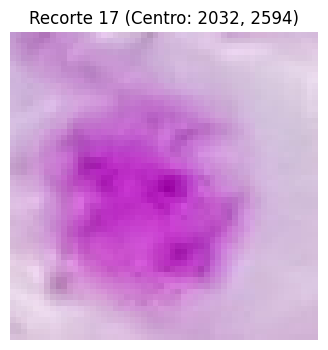

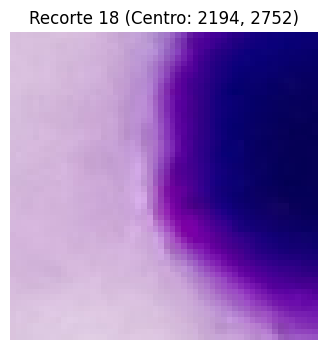

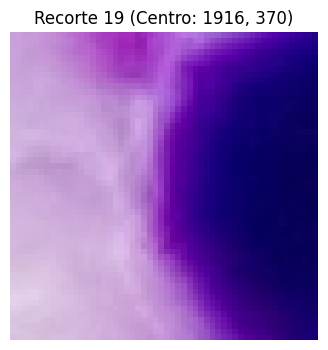

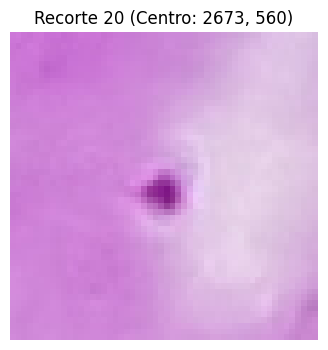

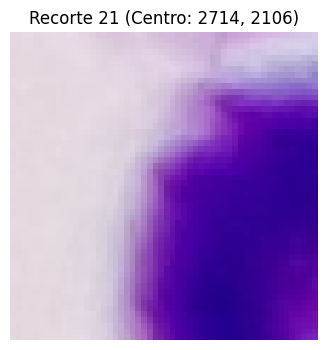

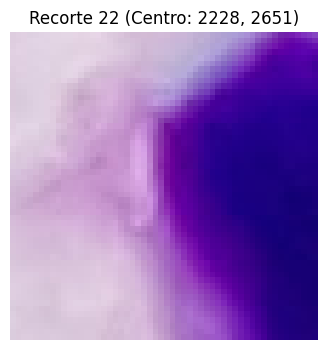

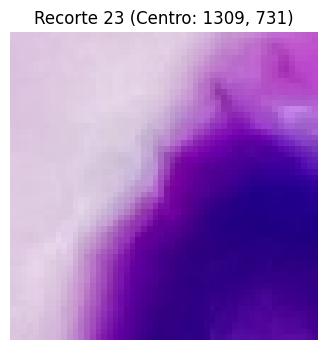

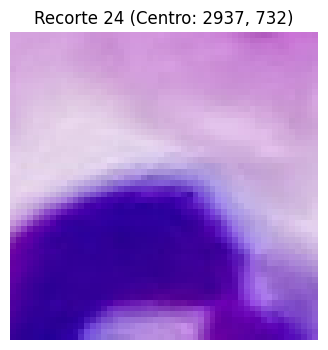

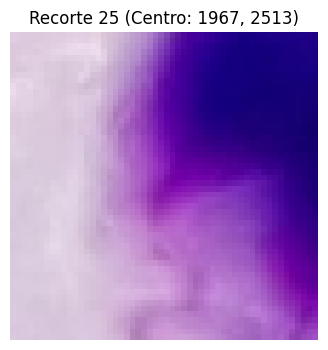

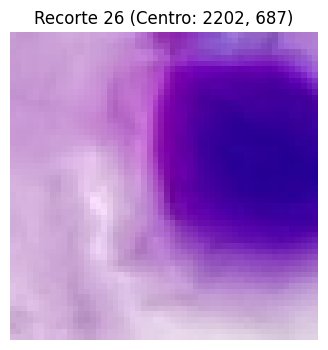

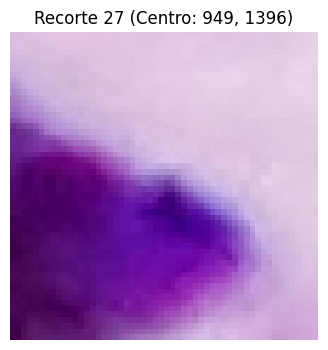

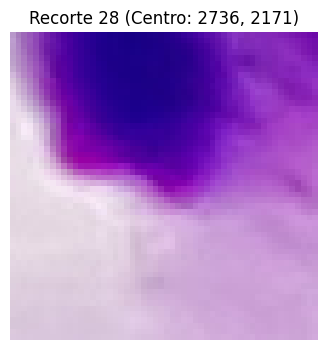

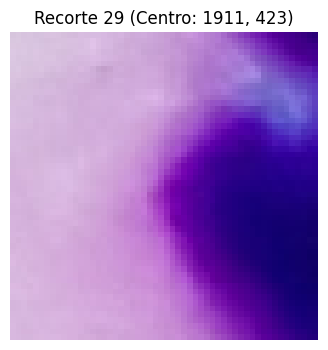

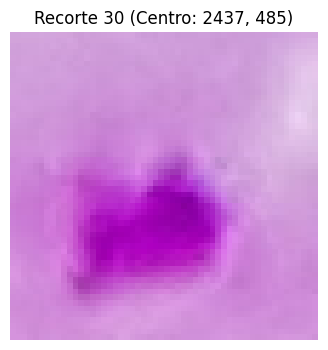

In [10]:
# Parámetro para ajustar el tamaño del recorte
factor_escala = 1  # Escalar el radio para que el recorte sea más amplio

# Crear una lista para almacenar los recortes y sus coordenadas
crop_regions = []

# Recortar cada candidato de la imagen original
for i, candidate in enumerate(parasite_candidates, start=1):  # Enumerar los candidatos
    x, y = candidate  # Coordenadas del centro del recorte (columna, fila)

    # Ajustar el radio según el factor de escala
    radio_ajustado = int(radio_parasito * factor_escala)

    # Definir los límites del recorte considerando el radio ajustado
    x_start = max(x - radio_ajustado, 0)
    x_end = min(x + radio_ajustado, image_rgb.shape[1])
    y_start = max(y - radio_ajustado, 0)
    y_end = min(y + radio_ajustado, image_rgb.shape[0])

    # Realizar el recorte
    crop = image_rgb[y_start:y_end, x_start:x_end]

    # Guardar el número del recorte, la imagen, y las coordenadas
    crop_regions.append({
        "id": i,                  # ID del recorte
        "recorte": crop,          # Imagen recortada
        "x_centro": x,            # Coordenada x del centro
        "y_centro": y,            # Coordenada y del centro
        "x_start": x_start,       # Límite izquierdo
        "x_end": x_end,           # Límite derecho
        "y_start": y_start,       # Límite superior
        "y_end": y_end,           # Límite inferior
    })

# Visualizar los recortes numerados
for recorte in crop_regions:  # Iterar por los recortes
    plt.figure(figsize=(4, 4))
    plt.imshow(recorte["recorte"])
    plt.title(f"Recorte {recorte['id']} (Centro: {recorte['x_centro']}, {recorte['y_centro']})")
    plt.axis("off")
    plt.show()


In [11]:
import pandas as pd

# Crear un DataFrame vacío para almacenar los datos
df_recortes = pd.DataFrame(columns=["id_recorte", "x_centro", "y_centro", "x_start", "x_end", "y_start", "y_end", "recorte"])

# Parámetro para ajustar el tamaño del recorte
factor_escala = 1  # Escalar el radio para que el recorte sea más amplio

# Recortar cada candidato de la imagen original
for i, candidate in enumerate(parasite_candidates, start=1):  # Enumerar los candidatos
    x, y = candidate  # Coordenadas del centro del recorte (columna, fila)

    # Ajustar el radio según el factor de escala
    radio_ajustado = int(radio_parasito * factor_escala)

    # Definir los límites del recorte considerando el radio ajustado
    x_start = max(x - radio_ajustado, 0)
    x_end = min(x + radio_ajustado, image_rgb.shape[1])
    y_start = max(y - radio_ajustado, 0)
    y_end = min(y + radio_ajustado, image_rgb.shape[0])

    # Realizar el recorte
    crop = image_rgb[y_start:y_end, x_start:x_end]

    # Agregar una fila al DataFrame
    df_recortes = pd.concat([
        df_recortes,
        pd.DataFrame({
            "id_recorte": [i],                # ID del recorte
            "x_centro": [x],          # Coordenada x del centro
            "y_centro": [y],          # Coordenada y del centro
            "x_start": [x_start],     # Límite izquierdo
            "x_end": [x_end],         # Límite derecho
            "y_start": [y_start],     # Límite superior
            "y_end": [y_end],         # Límite inferior
            "recorte": [crop],        # Imagen recortada (como matriz NumPy)
        })
    ], ignore_index=True)

# Visualizar los primeros recortes en el DataFrame
df_recortes

,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte
0,1,861,1403,834,888,1376,1430,"[[[219, 196, 222], [221, 198, 224], [221, 198,..."
1,2,907,1447,880,934,1420,1474,"[[[93, 28, 110], [93, 28, 110], [93, 28, 110],..."
2,3,2898,772,2871,2925,745,799,"[[[213, 159, 221], [212, 158, 218], [214, 160,..."
3,4,879,1429,852,906,1402,1456,"[[[216, 192, 224], [208, 178, 216], [195, 156,..."
4,5,943,1457,916,970,1430,1484,"[[[88, 28, 100], [87, 27, 99], [87, 27, 99], [..."
5,6,1982,2471,1955,2009,2444,2498,"[[[230, 216, 229], [231, 217, 230], [230, 216,..."
6,7,1963,2360,1936,1990,2333,2387,"[[[206, 167, 211], [205, 166, 210], [204, 167,..."
7,8,1914,324,1887,1941,297,351,"[[[181, 150, 226], [172, 144, 219], [173, 145,..."
8,9,1615,2372,1588,1642,2345,2399,"[[[170, 15, 181], [172, 17, 183], [180, 23, 19..."
9,10,1457,1135,1430,1484,1108,1162,"[[[197, 90, 204], [199, 92, 206], [195, 91, 20..."


## Relacionar candidatos con recortes

In [17]:
ruta_notas = '/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Notas - Thick Smear/TF1N_1522/20171023_110309.txt'

# Leer el archivo, saltando la primera línea
notas = pd.read_csv(ruta_notas, skiprows=1, header=None)

# Asignar los nombres de las columnas de acuerdo a la descripción
notas.columns = [
    'ID_nota',             # Identificador de la anotación (ej. 0-1, 0-2, etc.)
    'Type',           # Tipo de célula (Parasite o White_Blood_Cell)
    'Comment',        # Comentario adicional (No_Comment)
    'Shape',          # Forma (Circle o Point)
    'Label',          # Etiqueta (número 1 o 2)
    'X1',             # Coordenada X del centro del círculo o punto
    'Y1',             # Coordenada Y del centro del círculo o punto
    'X2',             # Coordenada X en la circunferencia (solo si es Circle)
    'Y2'              # Coordenada Y en la circunferencia (solo si es Circle)
]

# Ver el contenido cargado con las nuevas columnas
anotaciones_parasitos = notas[notas['Type'] == "Parasite"]
# Calcular el centro de las anotaciones
anotaciones_parasitos['centro_x'] = (anotaciones_parasitos['X1'] + anotaciones_parasitos['X2']) / 2
anotaciones_parasitos['centro_y'] = (anotaciones_parasitos['Y1'] + anotaciones_parasitos['Y2']) / 2

,ID_nota,Type,Comment,Shape,Label,X1,Y1,X2,Y2
0,0-1,Parasite,No_Comment,Circle,2,2675.35,566.00,2678.00,579.25
1,0-2,Parasite,No_Comment,Circle,2,2271.25,544.95,2260.65,555.55
2,0-3,Parasite,No_Comment,Circle,2,2388.10,887.60,2383.75,902.75
3,0-31,Parasite,No_Comment,Circle,2,2427.40,489.30,2439.15,512.85
4,0-4,Parasite,No_Comment,Circle,2,1663.10,968.20,1660.90,983.70
5,0-5,Parasite,No_Comment,Circle,2,2214.35,1225.80,2216.60,1239.30


In [19]:
anotaciones_parasitos

,ID_nota,Type,Comment,Shape,Label,X1,Y1,X2,Y2,centro_x,centro_y
0,0-1,Parasite,No_Comment,Circle,2,2675.35,566.00,2678.00,579.25,2676.675,572.625
1,0-2,Parasite,No_Comment,Circle,2,2271.25,544.95,2260.65,555.55,2265.950,550.250
2,0-3,Parasite,No_Comment,Circle,2,2388.10,887.60,2383.75,902.75,2385.925,895.175
3,0-31,Parasite,No_Comment,Circle,2,2427.40,489.30,2439.15,512.85,2433.275,501.075
4,0-4,Parasite,No_Comment,Circle,2,1663.10,968.20,1660.90,983.70,1662.000,975.950
5,0-5,Parasite,No_Comment,Circle,2,2214.35,1225.80,2216.60,1239.30,2215.475,1232.550


In [20]:
# Crear una lista para almacenar los resultados de las comparaciones
comparaciones = []

# Iterar por cada anotación de parásito
for index, anotacion in anotaciones_parasitos.iterrows():
    x_annot, y_annot = anotacion["centro_x"], anotacion["centro_y"]
    id_nota = anotacion['ID_nota']

    # Verificar si la anotación está dentro de algún recorte
    for recorte in crop_regions:
        if (recorte["x_start"] <= x_annot <= recorte["x_end"] and
            recorte["y_start"] <= y_annot <= recorte["y_end"]):
            comparaciones.append({
                "ID_nota" :id_nota,
                "id_recorte": recorte["id"],
                "x_anotacion": x_annot,
                "y_anotacion": y_annot,
                "contiene_parasito": True
            })
            break  # Dejar de buscar una vez que la anotación está asignada a un recorte

# Convertir las comparaciones en un DataFrame para análisis
df_comparaciones = pd.DataFrame(comparaciones)
print(df_comparaciones)

  ID_nota  id_recorte  x_anotacion  y_anotacion  contiene_parasito
0     0-1          20     2676.675      572.625               True
1     0-2          15     2265.950      550.250               True
2    0-31          30     2433.275      501.075               True
3     0-4          11     1662.000      975.950               True


In [21]:
crop_regions

[{'id': 1,
  'recorte': array([[[219, 196, 222],
          [221, 198, 224],
          [221, 198, 224],
          ...,
          [212, 188, 220],
          [210, 185, 217],
          [205, 177, 215]],
  
         [[219, 196, 222],
          [219, 196, 222],
          [220, 197, 223],
          ...,
          [205, 181, 215],
          [202, 178, 214],
          [201, 175, 214]],
  
         [[219, 196, 222],
          [219, 196, 222],
          [219, 196, 222],
          ...,
          [198, 172, 211],
          [197, 171, 210],
          [195, 166, 210]],
  
         ...,
  
         [[229, 212, 230],
          [227, 210, 228],
          [227, 210, 228],
          ...,
          [116,  69, 150],
          [118,  71, 152],
          [124,  77, 158]],
  
         [[228, 211, 229],
          [228, 211, 229],
          [228, 211, 229],
          ...,
          [119,  69, 154],
          [123,  74, 156],
          [134,  82, 165]],
  
         [[230, 213, 229],
          [230, 213, 229],
  

In [22]:
df_recortes

,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte
0,1,861,1403,834,888,1376,1430,"[[[219, 196, 222], [221, 198, 224], [221, 198,..."
1,2,907,1447,880,934,1420,1474,"[[[93, 28, 110], [93, 28, 110], [93, 28, 110],..."
2,3,2898,772,2871,2925,745,799,"[[[213, 159, 221], [212, 158, 218], [214, 160,..."
3,4,879,1429,852,906,1402,1456,"[[[216, 192, 224], [208, 178, 216], [195, 156,..."
4,5,943,1457,916,970,1430,1484,"[[[88, 28, 100], [87, 27, 99], [87, 27, 99], [..."
5,6,1982,2471,1955,2009,2444,2498,"[[[230, 216, 229], [231, 217, 230], [230, 216,..."
6,7,1963,2360,1936,1990,2333,2387,"[[[206, 167, 211], [205, 166, 210], [204, 167,..."
7,8,1914,324,1887,1941,297,351,"[[[181, 150, 226], [172, 144, 219], [173, 145,..."
8,9,1615,2372,1588,1642,2345,2399,"[[[170, 15, 181], [172, 17, 183], [180, 23, 19..."
9,10,1457,1135,1430,1484,1108,1162,"[[[197, 90, 204], [199, 92, 206], [195, 91, 20..."


In [23]:
df_comparaciones

,ID_nota,id_recorte,x_anotacion,y_anotacion,contiene_parasito
0,0-1,20,2676.675,572.625,True
1,0-2,15,2265.950,550.250,True
2,0-31,30,2433.275,501.075,True
3,0-4,11,1662.000,975.950,True


In [24]:
# Realizar el merge entre recortes y comparaciones
df_final = pd.merge(df_recortes, df_comparaciones, on="id_recorte", how="left")

# Crear una nueva columna 'es_parasito'
# Si 'contiene_parasito' es True, será 1, de lo contrario 0
df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)
df_final = df_final.drop(columns=["x_anotacion", "y_anotacion","contiene_parasito"])


df_final

<ipython-input-24-0093768093d3>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["es_parasito"] = df_final["contiene_parasito"].fillna(False).astype(int)


,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte,ID_nota,es_parasito
0,1,861,1403,834,888,1376,1430,"[[[219, 196, 222], [221, 198, 224], [221, 198,...",NaN,0
1,2,907,1447,880,934,1420,1474,"[[[93, 28, 110], [93, 28, 110], [93, 28, 110],...",NaN,0
2,3,2898,772,2871,2925,745,799,"[[[213, 159, 221], [212, 158, 218], [214, 160,...",NaN,0
3,4,879,1429,852,906,1402,1456,"[[[216, 192, 224], [208, 178, 216], [195, 156,...",NaN,0
4,5,943,1457,916,970,1430,1484,"[[[88, 28, 100], [87, 27, 99], [87, 27, 99], [...",NaN,0
5,6,1982,2471,1955,2009,2444,2498,"[[[230, 216, 229], [231, 217, 230], [230, 216,...",NaN,0
6,7,1963,2360,1936,1990,2333,2387,"[[[206, 167, 211], [205, 166, 210], [204, 167,...",NaN,0
7,8,1914,324,1887,1941,297,351,"[[[181, 150, 226], [172, 144, 219], [173, 145,...",NaN,0
8,9,1615,2372,1588,1642,2345,2399,"[[[170, 15, 181], [172, 17, 183], [180, 23, 19...",NaN,0
9,10,1457,1135,1430,1484,1108,1162,"[[[197, 90, 204], [199, 92, 206], [195, 91, 20...",NaN,0


In [25]:
# Ruta de ejemplo
ruta = "/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Dataset/Temporal/Imagenes - Thick Smear/TF1N_1522/20171023_110309.jpg"

# Regex para extraer los dos últimos segmentos
pattern = r".*/([^/]+)/([^/]+)\.[^/]+$"

# Buscar coincidencias
match = re.match(pattern, ruta)
if match:
    penultimo_segmento = match.group(1)  # "TF1N_1522"
    ultimo_segmento = match.group(2)     # "20171023_110309"
    print("Penúltimo segmento:", penultimo_segmento)
    print("Último segmento:", ultimo_segmento)
else:
    print("No se encontraron coincidencias.")


Penúltimo segmento: TF1N_1522
Último segmento: 20171023_110309


In [26]:
df_final["paciente"] = penultimo_segmento
df_final["imagen"] = ultimo_segmento

df_final

,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte,ID_nota,es_parasito,paciente,imagen
0,1,861,1403,834,888,1376,1430,"[[[219, 196, 222], [221, 198, 224], [221, 198,...",NaN,0,TF1N_1522,20171023_110309
1,2,907,1447,880,934,1420,1474,"[[[93, 28, 110], [93, 28, 110], [93, 28, 110],...",NaN,0,TF1N_1522,20171023_110309
2,3,2898,772,2871,2925,745,799,"[[[213, 159, 221], [212, 158, 218], [214, 160,...",NaN,0,TF1N_1522,20171023_110309
3,4,879,1429,852,906,1402,1456,"[[[216, 192, 224], [208, 178, 216], [195, 156,...",NaN,0,TF1N_1522,20171023_110309
4,5,943,1457,916,970,1430,1484,"[[[88, 28, 100], [87, 27, 99], [87, 27, 99], [...",NaN,0,TF1N_1522,20171023_110309
5,6,1982,2471,1955,2009,2444,2498,"[[[230, 216, 229], [231, 217, 230], [230, 216,...",NaN,0,TF1N_1522,20171023_110309
6,7,1963,2360,1936,1990,2333,2387,"[[[206, 167, 211], [205, 166, 210], [204, 167,...",NaN,0,TF1N_1522,20171023_110309
7,8,1914,324,1887,1941,297,351,"[[[181, 150, 226], [172, 144, 219], [173, 145,...",NaN,0,TF1N_1522,20171023_110309
8,9,1615,2372,1588,1642,2345,2399,"[[[170, 15, 181], [172, 17, 183], [180, 23, 19...",NaN,0,TF1N_1522,20171023_110309
9,10,1457,1135,1430,1484,1108,1162,"[[[197, 90, 204], [199, 92, 206], [195, 91, 20...",NaN,0,TF1N_1522,20171023_110309


In [27]:
import pandas as pd

# DataFrame global que consolidará los datos de todas las imágenes procesadas
df_global = pd.DataFrame()

# Agregar los DataFrames individuales al global
df_global = pd.concat([df_global, df_final], ignore_index=True)
df_global = pd.concat([df_global, df_final], ignore_index=True)

# Mostrar el DataFrame global
df_global


,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte,ID_nota,es_parasito,paciente,imagen
0,1,861,1403,834,888,1376,1430,"[[[219, 196, 222], [221, 198, 224], [221, 198,...",NaN,0,TF1N_1522,20171023_110309
1,2,907,1447,880,934,1420,1474,"[[[93, 28, 110], [93, 28, 110], [93, 28, 110],...",NaN,0,TF1N_1522,20171023_110309
2,3,2898,772,2871,2925,745,799,"[[[213, 159, 221], [212, 158, 218], [214, 160,...",NaN,0,TF1N_1522,20171023_110309
3,4,879,1429,852,906,1402,1456,"[[[216, 192, 224], [208, 178, 216], [195, 156,...",NaN,0,TF1N_1522,20171023_110309
4,5,943,1457,916,970,1430,1484,"[[[88, 28, 100], [87, 27, 99], [87, 27, 99], [...",NaN,0,TF1N_1522,20171023_110309
5,6,1982,2471,1955,2009,2444,2498,"[[[230, 216, 229], [231, 217, 230], [230, 216,...",NaN,0,TF1N_1522,20171023_110309
6,7,1963,2360,1936,1990,2333,2387,"[[[206, 167, 211], [205, 166, 210], [204, 167,...",NaN,0,TF1N_1522,20171023_110309
7,8,1914,324,1887,1941,297,351,"[[[181, 150, 226], [172, 144, 219], [173, 145,...",NaN,0,TF1N_1522,20171023_110309
8,9,1615,2372,1588,1642,2345,2399,"[[[170, 15, 181], [172, 17, 183], [180, 23, 19...",NaN,0,TF1N_1522,20171023_110309
9,10,1457,1135,1430,1484,1108,1162,"[[[197, 90, 204], [199, 92, 206], [195, 91, 20...",NaN,0,TF1N_1522,20171023_110309
